# Surface area duration plots <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** None
* **Special requirements:** CSV files containing [DEA Waterbodies](https://www.ga.gov.au/dea/products/dea-waterbodies) time series data (available online).
* **Prerequisites:** None


## Description

This notebook plots "surface area duration (SAD) curves", which show for how long a waterbody is filled at a given surface area. Such a curve can be generated for any DEA Waterbody. We also generate a time-dependent version of this plot called a "short-time surface area duration (STSAD) curve", which shows how the surface area duration curve varies over time.

The DEA Waterbodies time series are stored as CSV files. Each waterbody is labelled by a geohash, e.g. Weereewa is `r3f225n9h`. They are stored on both the NCI and S3 in a folder named after the first four characters of the geohash, and the filename is the geohash, e.g. Weereewa is at `https://data.dea.ga.gov.au/projects/WaterBodies/timeseries/r3f2/r3f225n9h.csv`. Each CSV has three columns: `Observation Date`, `Wet pixel percentage`, `Wet pixel count (n = ?)` where ? is some number. An example is:

    Observation Date,Wet pixel percentage,Wet pixel count (n = 230894)
    1987-05-29T23:14:29Z,,
    1987-07-16T23:15:29Z,,
    1987-09-02T23:16:50Z,,
    1987-09-18T23:17:13Z,19.9,45926

This analysis should work for any time series stored in a similar format.

***

## Getting started

Run the first cell, which loads all modules needed for this notebook. Then edit the configuration to match what you want the notebook to output.

### Configuration

To generate a plot for a waterbody with a given geohash, specify the geohash here:

In [1]:
geohash = "r3f225n9h"

Also specify the window for the STSAD plot. Use 'hann' if you have no opinions on this, or 'boxcar' if you want a window that is easy to think about:

In [2]:
window = "hann"

Finally, specify the path to the waterbodies CSVs:

In [3]:
# On the NCI in r78:
# waterbody_csv_path = '/g/data/r78/cek156/dea-notebooks/Scientific_workflows/DEAWaterbodies/timeseries_aus_uid'

# On the Sandbox:
waterbody_csv_path = "https://data.dea.ga.gov.au/projects/WaterBodies/timeseries"

### Load modules

In [4]:
from pathlib import Path

import numpy as np
import pandas as pd
import scipy.signal
from matplotlib import pyplot as plt

%matplotlib inline

### Load the data

In [5]:
# Read the CSV containing the surface area vs time observations.
csv_path = f"{waterbody_csv_path}/{geohash[:4]}/{geohash}.csv"
time_series = pd.read_csv(csv_path)
# Relabel the third column to something consistent (i.e. without the n = ?),
# and rename all columns to something easier to access.
time_series.rename(
    columns={
        "Observation Date": "date",
        "Wet pixel percentage": "pc_wet",
        time_series.columns[2]: "px_wet",
    },
    inplace=True,
)
# Convert time strings into datetimes.
time_series.date = pd.to_datetime(time_series.date)

In [1]:
# Convert percentages into a float between 0 and 1.
time_series.pc_wet /= 100

NameError: name 'time_series' is not defined

## Interpolate data to daily grid

Interpolate the data to a common grid.

Change the axis to daily:

In [2]:
# Converting from datetime64[ns] to datetime64[D] rounds to the nearest day.
dates = time_series.date.to_numpy().astype("datetime64[D]")

NameError: name 'time_series' is not defined

In [8]:
# Set the dataframe index to the day-rounded dates.
dt_index = np.arange(dates[0], dates[-1], 1)

In [9]:
time_series.index = dates

In [10]:
time_series = time_series.reindex(dt_index)

In [11]:
assert len(time_series) == len(dt_index)

Then interpolate (linearly, since it's the least-information thing other than constant).

In [3]:
# Replace NaNs with a linear interpolation of the time series.
time_series.pc_wet.interpolate(inplace=True, limit_direction="both")

NameError: name 'time_series' is not defined

## Calculate SADs

For each rolling time step, calculate the SADs.

In [13]:
def calculate_vector_stat(
    vec: "data dim",
    stat: "data dim -> target dim",
    window_size=365,
    step=10,
    target_dim=365,
    progress=None,
    window="hann",
):
    """Calculates a vector statistic over a rolling window.
    
    Parameters
    ----------
    vec : d-dimensional np.ndarray
        Vector to calculate over, e.g. a time series.
    stat : R^d -> R^t function
        Statistic function.
    window_size : int
        Sliding window size (default 365).
    step : int
        Step size (default 10).
    target_dim : int
        Dimensionality of the output of `stat` (default 365).
    progress : iterator -> iterator
        Optional progress decorator, e.g. tqdm.notebook.tqdm. Default None.
    window : str
        What kind of window function to use. Default 'hann', but you might
        also want to use 'boxcar'. Any scipy window
        function is allowed (see documentation for scipy.signal.get_window
        for more information).
        
    Returns
    -------
    (d / step)-dimensional np.ndarray
        y values (the time axis)
    t-dimensional np.ndarray
        x values (the statistic axis)
    (d / step) x t-dimensional np.ndarray
        The vector statistic array.
    """
    # Initialise output array.
    spectrogram_values = np.zeros((vec.shape[0] // step, target_dim))

    # Apply the progress decorator, if specified.
    r = range(0, vec.shape[0] - window_size, step)
    if progress:
        r = progress(r)

    # Convert the window str argument into a window function.
    window = scipy.signal.get_window(window, window_size)

    # Iterate over the sliding window and compute the statistic.
    for base in r:
        win = vec[base : base + window_size] * window
        sad = stat(win)
        spectrogram_values[base // step, :] = sad

    return (
        np.linspace(0, vec.shape[0], vec.shape[0] // step, endpoint=False),
        np.arange(target_dim),
        spectrogram_values,
    )

In [4]:
def _calculate_sad(vec):
    """Calculates the surface area duration curve for a given vector of heights.
    
    Parameters
    ----------
    vec : d-dimensional np.ndarray
        Vector of heights over time.
    
    Returns
    -------
    d-dimensional np.ndarray
        Surface area duration curve vector over the same time scale.
    """
    return np.sort(vec)[::-1]


def calculate_sad(vec, window_size=365, step=10, progress=None, window="hann"):
    """Calculates the short-time surface area duration curve for a given vector of heights.
    
    Parameters
    ----------
    vec : d-dimensional np.ndarray
        Vector of heights over time.
    window_size : int
        Sliding window size (default 365).
    step : int
        Step size (default 10).
    progress : iterator -> iterator
        Optional progress decorator, e.g. tqdm.notebook.tqdm. Default None.
    window : str
        What kind of window function to use. Default 'hann', but you might
        also want to use 'boxcar'. Any scipy window
        function is allowed (see documentation for scipy.signal.get_window
        for more information).
    
    Returns
    -------
    (d / step)-dimensional np.ndarray
        y values (the time axis)
    t-dimensional np.ndarray
        x values (the statistic axis)
    (d / step) x t-dimensional np.ndarray
        The short-time surface area duration curve array.
    """
    return calculate_vector_stat(
        vec,
        _calculate_sad,
        window_size=window_size,
        step=step,
        target_dim=window_size,
        progress=progress,
        window=window,
    )


Calculate the STSAD.

In [5]:
sad_y, sad_x, sads = calculate_sad(
    time_series.pc_wet, window_size=365 * 2, window=window, step=10
)

NameError: name 'time_series' is not defined

Convert the time axis into integers for calculating tick locations.

In [16]:
year_starts = (time_series.index.month == 1) & (time_series.index.day == 1)
year_start_days = (time_series.index - time_series.index[0])[year_starts].days
year_start_years = time_series.index.year[year_starts]

Calculate the overall SAD.

In [17]:
sad = _calculate_sad(time_series.pc_wet)

## Plot SADs

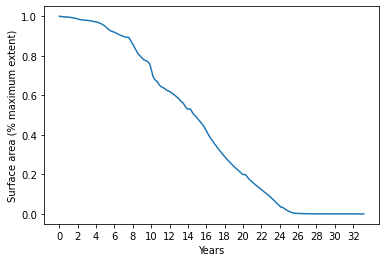

In [18]:
plt.figure()
plt.plot(sad)
plt.xlabel("Years")
xs = np.arange(0, len(sad), 365)
plt.xticks(xs[::2], np.arange(len(xs))[::2])
plt.ylabel("Surface area (% maximum extent)");

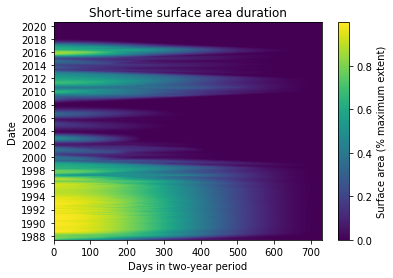

In [19]:
plt.figure()
plt.pcolormesh(sad_x, sad_y, sads)
plt.xlabel("Days in two-year period")
plt.yticks(year_start_days[::2], year_start_years[::2])
plt.ylabel("Date")
plt.colorbar(label="Surface area (% maximum extent)")
plt.title("Short-time surface area duration");

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** September 2020

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html).